### Segmentasi Pasien Berbasis Profil Klinis

In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Step 0: Load CSVs
df_patient = pd.read_csv('../data/csvdata/patient.csv')
df_observation = pd.read_csv('../data/csvdata/observation.csv')
df_condition = pd.read_csv('../data/csvdata/condition.csv')
df_encounter = pd.read_csv('../data/csvdata/encounter.csv')
df_medical_procedure = pd.read_csv('../data/csvdata/medical_procedure.csv')

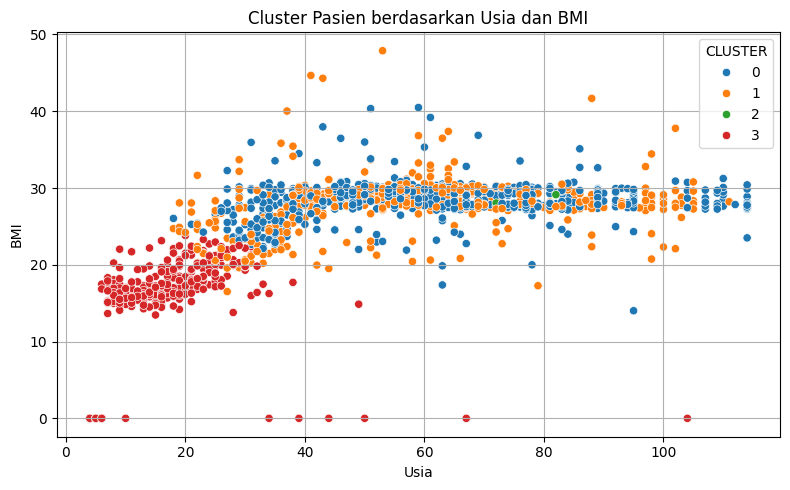

In [11]:
# Step 1: Proses data patient
df_patient['BIRTH_DATE'] = pd.to_datetime(df_patient['BIRTH_DATE'], errors='coerce')
df_patient['AGE'] = (pd.Timestamp.now() - df_patient['BIRTH_DATE']).dt.days // 365
df_patient = df_patient[['ID', 'AGE', 'GENDER']]

# Step 2: Ambil BMI dari observation
df_bmi = df_observation[df_observation['TEXT'].str.lower() == 'body mass index'][['ENCOUNTER_ID', 'VALUE']]
df_bmi = df_bmi.rename(columns={'VALUE': 'BMI'})

# Step 3: Gabungkan BMI ke patient via encounter → patient
df_enc = df_encounter[['ID', 'PATIENT_ID']]
df_bmi_enc = pd.merge(df_bmi, df_enc, left_on='ENCOUNTER_ID', right_on='ID')[['PATIENT_ID', 'BMI']]
df_bmi_agg = df_bmi_enc.groupby('PATIENT_ID')['BMI'].mean().reset_index()

# Step 4: Jumlah encounter per pasien
df_enc_count = df_encounter.groupby('PATIENT_ID').size().reset_index(name='ENCOUNTER_COUNT')

# Step 5: Jumlah prosedur per pasien
df_proc = pd.merge(df_medical_procedure, df_encounter[['ID', 'PATIENT_ID']], left_on='ENCOUNTER_ID', right_on='ID')
df_proc_count = df_proc.groupby('PATIENT_ID').size().reset_index(name='PROCEDURE_COUNT')

# Step 6: Gabungkan semua ke df fitur
df_feat = df_patient.rename(columns={'ID': 'PATIENT_ID'})
df_feat = pd.merge(df_feat, df_bmi_agg, on='PATIENT_ID', how='left')
df_feat = pd.merge(df_feat, df_enc_count, on='PATIENT_ID', how='left')
df_feat = pd.merge(df_feat, df_proc_count, on='PATIENT_ID', how='left')

# Step 7: Preprocessing
df_feat['GENDER'] = df_feat['GENDER'].str.lower().map({'male': 1, 'female': 0})
df_feat.fillna(0, inplace=True)

# Step 8: Clustering
features = ['AGE', 'GENDER', 'BMI', 'ENCOUNTER_COUNT', 'PROCEDURE_COUNT']
X = df_feat[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
df_feat['CLUSTER'] = kmeans.fit_predict(X_scaled)

# Step 9: Visualisasi hasil cluster
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_feat, x='AGE', y='BMI', hue='CLUSTER', palette='tab10')
plt.title('Cluster Pasien berdasarkan Usia dan BMI')
plt.xlabel('Usia')
plt.ylabel('BMI')
plt.grid(True)
plt.tight_layout()

# df_feat[['PATIENT_ID', 'AGE', 'GENDER', 'BMI', 'ENCOUNTER_COUNT', 'PROCEDURE_COUNT', 'CLUSTER']].head(20)

mengidentifikasi kelompok pasien berdasarkan profil risiko kesehatan mereka

cluster 0: 	Usia menengah–tua (40–90), BMI 28–32

cluster 1: 	Usia luas (20–90), BMI beragam (20–45)

cluster 2: Jumlah sedikit, berada di pusat distribusi

cluster 3: Anak–remaja (usia < 25), BMI < 25

Early Warning System: Cluster bisa dipakai untuk mengidentifikasi pasien yang berisiko memerlukan perawatan intensif

Berdasarkan hasil clustering pasien menggunakan variabel usia dan indeks massa tubuh (BMI), diperoleh empat segmen utama populasi dengan karakteristik yang berbeda. Cluster berwarna merah mendominasi kelompok usia muda dengan BMI rendah hingga normal, mengindikasikan kondisi gizi yang baik pada populasi remaja dan dewasa awal. Sementara itu, cluster biru dan oranye merepresentasikan kelompok usia dewasa hingga lanjut usia dengan BMI cenderung meningkat, menunjukkan tren peningkatan risiko kelebihan berat badan atau obesitas seiring bertambahnya usia. Cluster hijau muncul sebagai outlier dengan distribusi terbatas, kemungkinan merepresentasikan kasus ekstrem atau pencilan data. Visualisasi ini mempertegas pentingnya pemantauan status gizi lintas kelompok usia dalam upaya pencegahan penyakit tidak menular, dan dapat menjadi dasar intervensi nutrisi yang lebih terarah oleh pihak Kementerian Kesehatan.

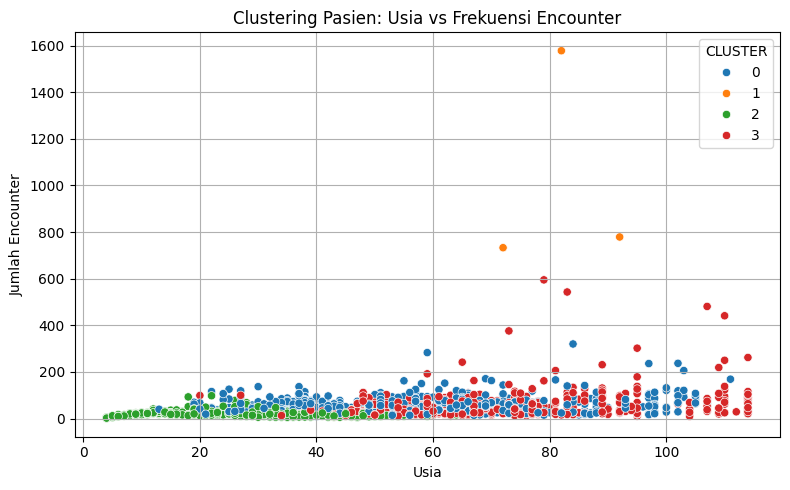

In [ ]:
# Load all required CSVs again
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df_patient = pd.read_csv('../data/csvdata/patient.csv')
df_encounter = pd.read_csv('../data/csvdata/encounter.csv')
df_condition = pd.read_csv('../data/csvdata/condition.csv')
df_medical_procedure = pd.read_csv('../data/csvdata/medical_procedure.csv')

# Step 1: Prepare patient age and gender
df_patient['BIRTH_DATE'] = pd.to_datetime(df_patient['BIRTH_DATE'], errors='coerce')
df_patient['AGE'] = (pd.Timestamp.now() - df_patient['BIRTH_DATE']).dt.days // 365
df_patient = df_patient[['ID', 'AGE', 'GENDER']].rename(columns={'ID': 'PATIENT_ID'})
df_patient['GENDER'] = df_patient['GENDER'].str.lower().map({'male': 1, 'female': 0})

# Step 2: Count number of encounters per patient
df_enc_count = df_encounter.groupby('PATIENT_ID').size().reset_index(name='ENCOUNTER_COUNT')

# Step 3: Count number of conditions per patient (via encounter)
df_cond_enc = pd.merge(df_condition, df_encounter[['ID', 'PATIENT_ID']], left_on='ENCOUNTER_ID', right_on='ID')
df_cond_count = df_cond_enc.groupby('PATIENT_ID').size().reset_index(name='CONDITION_COUNT')

# Step 4: Count number of procedures per patient (via encounter)
df_proc_enc = pd.merge(df_medical_procedure, df_encounter[['ID', 'PATIENT_ID']], left_on='ENCOUNTER_ID', right_on='ID')
df_proc_count = df_proc_enc.groupby('PATIENT_ID').size().reset_index(name='PROCEDURE_COUNT')

# Step 5: Merge all features
df_features = df_patient.copy()
df_features = pd.merge(df_features, df_enc_count, on='PATIENT_ID', how='left')
df_features = pd.merge(df_features, df_cond_count, on='PATIENT_ID', how='left')
df_features = pd.merge(df_features, df_proc_count, on='PATIENT_ID', how='left')
df_features.fillna(0, inplace=True)

# Step 6: Clustering
selected_features = ['AGE', 'GENDER', 'ENCOUNTER_COUNT', 'CONDITION_COUNT', 'PROCEDURE_COUNT']
X = df_features[selected_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_features['CLUSTER'] = kmeans.fit_predict(X_scaled)

# Step 7: Visualize
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_features, x='AGE', y='ENCOUNTER_COUNT', hue='CLUSTER', palette='tab10')
plt.title('Clustering Pasien: Usia vs Frekuensi Encounter')
plt.xlabel('Usia')
plt.ylabel('Jumlah Encounter')
plt.grid(True)
plt.tight_layout()

Siapa pasien yang sering mengakses layanan medis?

Apakah ada kelompok usia tertentu yang menyumbang beban layanan tertinggi?

Apakah pasien tua identik dengan frekuensi kunjungan tinggi?

X-axis = Usia pasien

Y-axis = Jumlah kunjungan ke layanan kesehatan (encounter)


Berdasarkan hasil clustering pasien,  dapat disimpulkan bahwa populasi pasien secara alami terbagi ke dalam empat kelompok utama berdasarkan usia dan frekuensi kunjungan ke fasilitas kesehatan. Terlihat bahwa sebagian besar pasien muda berada pada kelompok dengan frekuensi kunjungan rendah, mencerminkan kondisi kesehatan yang relatif stabil atau kunjungan preventif ringan. Sementara itu, kelompok usia lanjut tersebar di berbagai cluster, dengan sebagian menunjukkan frekuensi encounter yang sangat tinggi — kemungkinan merepresentasikan pasien dengan kondisi kronis atau komorbiditas yang memerlukan pemantauan intensif. Temuan ini menunjukkan pentingnya pendekatan layanan kesehatan yang disesuaikan dengan profil klinis dan demografis pasien, guna mengoptimalkan alokasi sumber daya dan efektivitas intervensi kesehatan masyarakat.

### PCA Approach
PCA bertujuan untuk menyederhanakan data berdimensi tinggi (misalnya 10 variabel: usia, BMI, tekanan darah, jumlah penyakit, dll.) menjadi beberapa komponen utama (PC) yang tetap mempertahankan informasi paling penting.

PC1 (Principal Component 1) adalah dimensi baru pertama yang menangkap variasi data terbesar. Artinya, perbedaan antar pasien yang paling mencolok ditangkap oleh sumbu PC1.

PC2 (Principal Component 2) adalah dimensi kedua, yang menangkap variasi terbesar kedua setelah PC1, dan selalu tegak lurus (orthogonal) terhadap PC1. PC2 biasanya menyoroti perbedaan pola tambahan yang tidak bisa ditangkap PC1.

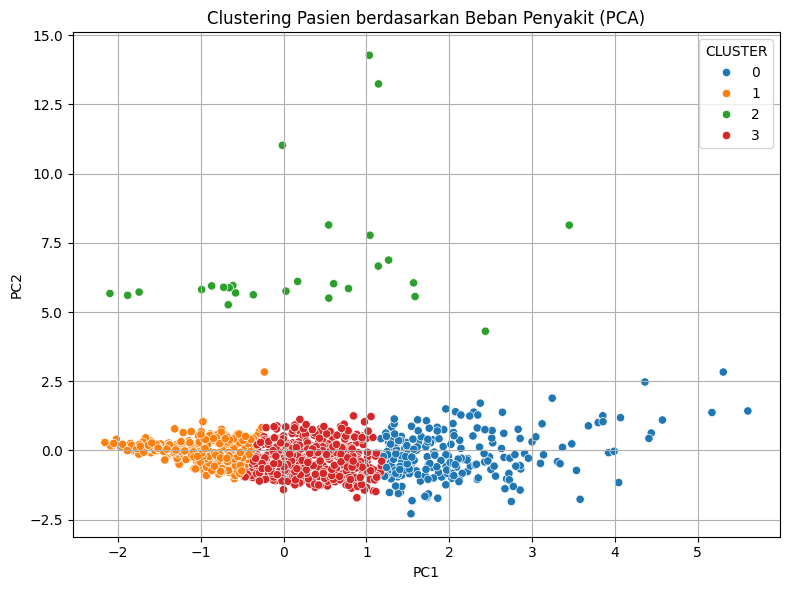

In [25]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# === LOAD CSV ===
df_condition = pd.read_csv('../data/csvdata/condition.csv')
df_encounter = pd.read_csv('../data/csvdata/encounter.csv')
df_code_ref = pd.read_csv('../data/csvdata/condition_code_ref.csv')  # harus punya kolom: SNOMED_CODE dan DISEASE_CATEGORY

# === JOIN untuk dapatkan PATIENT_ID ===
df_condition_enc = pd.merge(df_condition, df_encounter[['ID', 'PATIENT_ID']], 
                            left_on='ENCOUNTER_ID', right_on='ID', how='left')

# === Gabungkan dengan kategori penyakit ===
df_condition_cat = pd.merge(df_condition_enc, df_code_ref[['SNOMED_CODE', 'DISEASE_CATEGORY']], 
                            left_on='CODE', right_on='SNOMED_CODE', how='left')

# === Ambil hanya kolom yang relevan dan drop NA ===
df_condition_cat = df_condition_cat[['PATIENT_ID', 'DISEASE_CATEGORY']].dropna()

# === Hitung jumlah penyakit per kategori per pasien ===
df_disease_load = df_condition_cat.groupby(['PATIENT_ID', 'DISEASE_CATEGORY']) \
                                  .size().unstack(fill_value=0)

# === Normalisasi dan PCA ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_disease_load)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# === Clustering ===
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

# === Visualisasi ===
df_vis = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_vis['CLUSTER'] = clusters

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_vis, x='PC1', y='PC2', hue='CLUSTER', palette='tab10')
plt.title('Clustering Pasien berdasarkan Beban Penyakit (PCA)')
plt.grid(True)
plt.tight_layout()
plt.show()


pengelompokan pasien berdasarkan pola dan jumlah penyakit yang mereka alami.

Cluster biru (0) mendominasi dan merepresentasikan pasien dengan beban penyakit yang umum dan tersebar merata.

Cluster hijau (2) tampak terpisah secara signifikan di sumbu PC2, mengindikasikan kelompok pasien dengan beban penyakit yang jauh lebih kompleks atau multiple chronic conditions

Cluster merah (3) dan oranye (1) cenderung berkumpul di area tengah, menunjukkan kelompok pasien dengan penyakit yang lebih ringan atau spesifik.

Analisis ini membantu untuk merancang strategi layanan kesehatan yang lebih personal (tepat sasaran), seperti intervensi intensif untuk cluster risiko tinggi dan program pencegahan untuk cluster yang masih sehat.

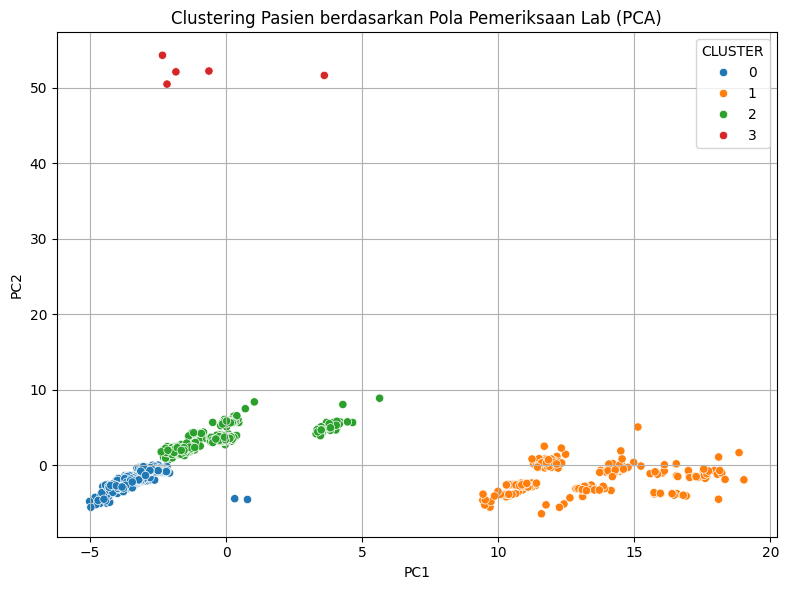

In [26]:
# Ambil kolom TEXT, VALUE, dan ENCOUNTER_ID
df_obs_lab_raw = df_observation[['TEXT', 'VALUE', 'ENCOUNTER_ID']].dropna()
df_obs_lab_raw['VALUE'] = pd.to_numeric(df_obs_lab_raw['VALUE'], errors='coerce')
df_obs_lab_raw = df_obs_lab_raw.dropna()

# Gabungkan ENCOUNTER_ID → PATIENT_ID
df_enc_map = df_encounter[['ID', 'PATIENT_ID']].rename(columns={'ID': 'ENCOUNTER_ID'})
df_obs_lab = pd.merge(df_obs_lab_raw, df_enc_map, on='ENCOUNTER_ID', how='inner')

# Pivot: pasien x jenis pemeriksaan lab
df_lab_pivot = df_obs_lab.pivot_table(index='PATIENT_ID', columns='TEXT', values='VALUE', aggfunc='mean').fillna(0)

# PCA dan Clustering
scaler = StandardScaler()
lab_scaled = scaler.fit_transform(df_lab_pivot)

pca = PCA(n_components=2)
lab_pca = pca.fit_transform(lab_scaled)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(lab_scaled)

# Visualisasi
df_lab_clustered = pd.DataFrame(lab_pca, columns=['PC1', 'PC2'])
df_lab_clustered['CLUSTER'] = clusters

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_lab_clustered, x='PC1', y='PC2', hue='CLUSTER', palette='tab10')
plt.title('Clustering Pasien berdasarkan Pola Pemeriksaan Lab (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.tight_layout()
plt.show()

hasil clustering ini menunjukkan segmentasi pasien berdasarkan pola hasil pemeriksaan laboratorium vital seperti tekanan darah, suhu tubuh, kadar hemoglobin, dan detak jantung. Hasil PCA dan clustering KMeans berhasil mengelompokkan pasien menjadi empat klaster utama dengan karakteristik berbeda. Cluster 0 (biru) cenderung memiliki hasil pemeriksaan dalam rentang normal dan stabil, merepresentasikan populasi pasien sehat atau tanpa kelainan signifikan. Cluster 1 (oranye) menunjukkan nilai pemeriksaan lebih tinggi dari rata-rata, mengindikasikan kemungkinan pasien dengan kondisi hipertensi atau abnormalitas metabolik. Cluster 2 (hijau) berada di area transisi, kemungkinan mewakili pasien dengan hasil fluktuatif atau dalam pemantauan. Sementara itu, Cluster 3 (merah) sangat terpisah dan ekstrem pada dimensi PCA ke-2, menandakan kemungkinan pasien dengan kondisi kronis atau abnormalitas laboratorium serius. Segmentasi ini dapat membantu Kementerian Kesehatan dalam menyusun prioritas intervensi dan perencanaan program pencegahan berdasarkan profil pemeriksaan klinis populasi.

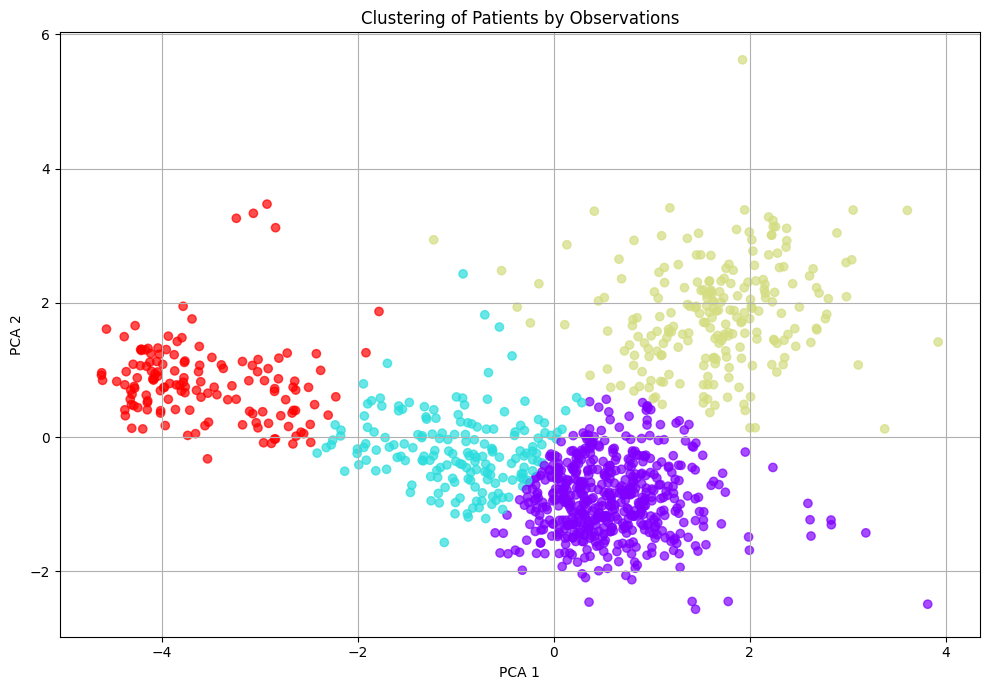

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load data (ganti path sesuai kebutuhan)
df_obs = pd.read_csv('../data/csvdata/observation.csv')
df_enc = pd.read_csv('../data/csvdata/encounter.csv')

# Ambil nilai observasi vital yang umum dan representatif
vital_obs = [
    'blood pressure', 'body weight', 'body height', 'body mass index',
    'respiratory rate', 'heart rate', 'body temperature',
    'oxygen saturation in arterial blood'
]

# Filter hanya data relevan
df_obs = df_obs[df_obs['TEXT'].str.lower().isin(vital_obs)]
df_obs = df_obs[df_obs['VALUE'].notna()]

# Join dengan patient ID via encounter
df_obs = df_obs.merge(df_enc[['ID', 'PATIENT_ID']], left_on='ENCOUNTER_ID', right_on='ID')
df_obs = df_obs[['PATIENT_ID', 'TEXT', 'VALUE']]

# Pivot agar tiap pasien jadi 1 baris, kolom = observasi
df_pivot = df_obs.pivot_table(index='PATIENT_ID', columns='TEXT', values='VALUE', aggfunc='mean')
df_pivot = df_pivot.dropna()

# Standardisasi dan PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pivot)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_pca)

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='rainbow', alpha=0.7)
plt.title('Clustering of Patients by Observations')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.tight_layout()
plt.show()


Visualisasi clustering ini menunjukkan pengelompokan pasien berdasarkan pola hasil pemeriksaan laboratorium dan observasi vital mereka, seperti tekanan darah, berat badan, kadar oksigen, dan lainnya. Dengan menggunakan algoritma K-Means dan reduksi dimensi PCA, kita berhasil memetakan ribuan pasien ke dalam empat kluster utama berdasarkan kesamaan nilai-nilai observasi mereka.

Tiap kluster merepresentasikan kelompok pasien dengan profil klinis yang serupa:

Kluster ungu kemungkinan merepresentasikan pasien dengan parameter vital yang tergolong normal dan stabil.

Kluster hijau muda mungkin terdiri dari pasien dengan observasi yang lebih tinggi, seperti tekanan darah atau berat badan di atas rata-rata.

Kluster biru muda bisa menunjukkan pasien dengan tren menengah atau fluktuatif, mungkin karena pemeriksaan berulang.

Kluster merah tampaknya merupakan pasien dengan nilai-nilai pengukuran yang cenderung rendah atau tidak normal, bisa jadi mewakili kelompok pasien dengan kebutuhan observasi klinis khusus.

Pemetaan ini sangat berguna untuk mengidentifikasi kelompok risiko, merancang program intervensi spesifik, dan memprioritaskan pelayanan kesehatan berdasarkan profil pemeriksaan laboratorium. Dengan demikian, bisa mempercepat kebijakan berbasis bukti di sektor pelayanan kesehatan publik.